# Mask R-CNN Demo

A quick intro to using the pre-trained model to detect and segment objects.

In [9]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt
import random
import itertools
import colorsys
from PIL import Image, ImageDraw, ImageFont
import matplotlib.font_manager as fm
from pytube import YouTube
# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
import coco

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

## Configurations

We'll be using a model trained on the MS-COCO dataset. The configurations of this model are in the ```CocoConfig``` class in ```coco.py```.

For inferencing, modify the configurations a bit to fit the task. To do so, sub-class the ```CocoConfig``` class and override the attributes you need to change.

In [10]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## Create Model and Load Trained Weights

In [11]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


## Class Names

The model classifies objects and returns class IDs, which are integer value that identify each class. Some datasets assign integer values to their classes and some don't. For example, in the MS-COCO dataset, the 'person' class is 1 and 'teddy bear' is 88. The IDs are often sequential, but not always. The COCO dataset, for example, has classes associated with class IDs 70 and 72, but not 71.

To improve consistency, and to support training on data from multiple sources at the same time, our ```Dataset``` class assigns it's own sequential integer IDs to each class. For example, if you load the COCO dataset using our ```Dataset``` class, the 'person' class would get class ID = 1 (just like COCO) and the 'teddy bear' class is 78 (different from COCO). Keep that in mind when mapping class IDs to class names.

To get the list of class names, you'd load the dataset and then use the ```class_names``` property like this.
```
# Load COCO dataset
dataset = coco.CocoDataset()
dataset.load_coco(COCO_DIR, "train")
dataset.prepare()

# Print class names
print(dataset.class_names)
```

We don't want to require you to download the COCO dataset just to run this demo, so we're including the list of class names below. The index of the class name in the list represent its ID (first class is 0, second is 1, third is 2, ...etc.)

In [12]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

In [13]:
def apply_mask(image, mask, color, alpha=0.5):
    """Apply the given mask to the image.
    """
    for c in range(3):
        image[:, :, c] = np.where(mask == 1,
                                  image[:, :, c] *
                                  (1 - alpha) + alpha * color[c] * 255,
                                  image[:, :, c])
    return image


In [14]:
def random_colors(N, bright=True):
    """
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then
    convert to RGB.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors


In [16]:
def save_image(image, image_name, boxes, masks, class_ids, scores, class_names, filter_classs_names=None,
               scores_thresh=0.1, save_dir=None, mode=0):
    """
        image: image array
        image_name: image name
        boxes: [num_instance, (y1, x1, y2, x2, class_id)] in image coordinates.
        masks: [num_instances, height, width]
        class_ids: [num_instances]
        scores: confidence scores for each box
        class_names: list of class names of the dataset
        filter_classs_names: (optional) list of class names we want to draw
        scores_thresh: (optional) threshold of confidence scores
        save_dir: (optional) the path to store image
        mode: (optional) select the result which you want
                mode = 0 , save image with bbox,class_name,score and mask;
                mode = 1 , save image with bbox,class_name and score;
                mode = 2 , save image with class_name,score and mask;
                mode = 3 , save mask with black background;
    """
    mode_list = [0, 1, 2, 3]
    assert mode in mode_list, "mode's value should in mode_list %s" % str(mode_list)

    if save_dir is None:
        save_dir = os.path.join(os.getcwd(), "output")
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)

    useful_mask_indices = []

    N = boxes.shape[0]
    if not N:
        print("\n*** No instances in image %s to draw *** \n" % (image_name))
        return
    else:
        assert boxes.shape[0] == masks.shape[-1] == class_ids.shape[0]

    for i in range(N):
        # filter
        class_id = class_ids[i]
        score = scores[i] if scores is not None else None
        if score is None or score < scores_thresh:
            continue

        label = class_names[class_id]
        if (filter_classs_names is not None) and (label not in filter_classs_names):
            continue

        if not np.any(boxes[i]):
            # Skip this instance. Has no bbox. Likely lost in image cropping.
            continue

        useful_mask_indices.append(i)

    if len(useful_mask_indices) == 0:
        print("\n*** No instances in image %s to draw *** \n" % (image_name))
        return

    colors = random_colors(len(useful_mask_indices))

    if mode != 3:
        masked_image = image.astype(np.uint8).copy()
    else:
        masked_image = np.zeros(image.shape).astype(np.uint8)

    if mode != 1:
        for index, value in enumerate(useful_mask_indices):
            masked_image = apply_mask(masked_image, masks[:, :, value], colors[index])

    masked_image = Image.fromarray(masked_image)

    if mode == 3:
        masked_image.save(os.path.join(save_dir, '%s.jpg' % (image_name)))
        return

    draw = ImageDraw.Draw(masked_image)
    colors = np.array(colors).astype(int) * 255

    for index, value in enumerate(useful_mask_indices):
        class_id = class_ids[value]
        score = scores[value]
        label = class_names[class_id]

        y1, x1, y2, x2 = boxes[value]
        if mode != 2:
            color = tuple(colors[index])
            draw.rectangle((x1, y1, x2, y2), outline=color)

        # Label
        #font = ImageFont.truetype("arial.ttf", 15)
        #draw.text((x1, y1), "%s %f" % (label, score), (255, 255, 255), font)
        draw.text((x1, y1), "%s %f" % (label, score), (255, 255, 255))

    masked_image.save(os.path.join(save_dir, '%s.jpg' % (image_name)))

## Run Object Detection

Processing 1 images
image                    shape: (640, 425, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


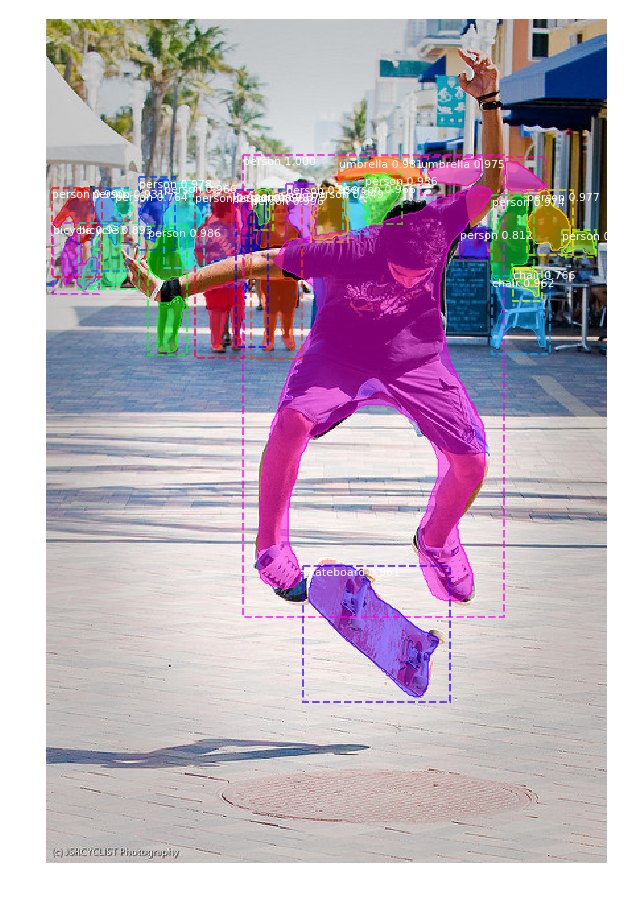

In [25]:
# Load a random image from the images folder
file_names = next(os.walk(IMAGE_DIR))[2]
image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))

# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

In [46]:
save_image(image, 'image_name', r['rois'], r['masks'],r['class_ids'],r['scores'],class_names,mode=0)

In [3]:
YouTube('https://www.youtube.com/watch?v=IGQBtbKSVhY').streams.first().download(filename='video')

'/userhome/comp3314/c3314g15/MaskRCNN-Extension/samples/video.mp4'

In [6]:
!ffmpeg -i video.mp4 -vf fps=30 img/output%04d.png

ffmpeg version 3.4.4-0ubuntu0.18.04.1 Copyright (c) 2000-2018 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.3.0-16ubuntu3)
  configuration: --prefix=/usr --extra-version=0ubuntu0.18.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --ena

In [18]:
import glob
count = 0
for filename in glob.glob('img/*.png'): #assuming gif
    image = skimage.io.imread(filename)
    results = model.detect([image], verbose=1)
    r = results[0]
    count += 1
    image_name = 'image_'+str(count)
    save_image(image, image_name, r['rois'], r['masks'],r['class_ids'],r['scores'],class_names,save_dir='output',mode=0)
    
    
    

Processing 1 images
image                    shape: (720, 1280, 3)        min:   18.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Processing 1 images
image                    shape: (720, 1280, 3)        min:   39.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Processing 1 images
image                    shape: (720, 1280, 3)        min:   26.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.1


*** No instances in image image_20 to draw *** 

Processing 1 images
image                    shape: (720, 1280, 3)        min:   14.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Processing 1 images
image                    shape: (720, 1280, 3)        min:   32.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Processing 1 images
image                    shape: (720, 1280, 3)        min:   27.00000  max:  255.00000  uint8
molded_images            shape: 

Processing 1 images
image                    shape: (720, 1280, 3)        min:   32.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Processing 1 images
image                    shape: (720, 1280, 3)        min:   16.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Processing 1 images
image                    shape: (720, 1280, 3)        min:   17.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.1

Processing 1 images
image                    shape: (720, 1280, 3)        min:   14.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Processing 1 images
image                    shape: (720, 1280, 3)        min:   39.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Processing 1 images
image                    shape: (720, 1280, 3)        min:   27.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.1

Processing 1 images
image                    shape: (720, 1280, 3)        min:   32.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Processing 1 images
image                    shape: (720, 1280, 3)        min:   14.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Processing 1 images
image                    shape: (720, 1280, 3)        min:   19.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.1

Processing 1 images
image                    shape: (720, 1280, 3)        min:   16.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Processing 1 images
image                    shape: (720, 1280, 3)        min:   30.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Processing 1 images
image                    shape: (720, 1280, 3)        min:   17.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.1

Processing 1 images
image                    shape: (720, 1280, 3)        min:   17.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Processing 1 images
image                    shape: (720, 1280, 3)        min:   17.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Processing 1 images
image                    shape: (720, 1280, 3)        min:   34.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.1

In [22]:
!ffmpeg -framerate 30 -i output/*.jpg video.mp4

ffmpeg version 3.4.4-0ubuntu0.18.04.1 Copyright (c) 2000-2018 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.3.0-16ubuntu3)
  configuration: --prefix=/usr --extra-version=0ubuntu0.18.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --ena